# CSCI 250 Final Project

- **Members**: Christopher Zimbizi, Michael Nsibande

- **About Dataset**:
  - Link to the dataset: https://www.kaggle.com/datasets/msambare/fer2013
  - The data consists of 48x48 pixel grayscale images of faces. 
  - The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

- **Task**:
  - The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). 
  - The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

# Why we chose our project 

- Mahcine learning continues to be a talking point in mainstrem media for it's many applications and its preliforance in our day to day lives. Models such as Chat GPT  seem to be in the news everyday and their abilities seem endelss if someone were to just look at what the media is saying about them.

- Although we wanted to look into something that we consder distinctly human, emotions and how we express them as we believe that ability to be a distinctly human ability. 
- This led us into looking into whether a mchine learning mdoel could learn facial expressions and seeting out on how we could do so.


## Imports

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Dropout,
    Flatten,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

## Check GPU status

In [33]:
import tensorflow as tf

devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Parameters

In [34]:
# Define paths
train_dir = "Data/train"
test_dir = "Data/test"

# Define emotions
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 48, 48

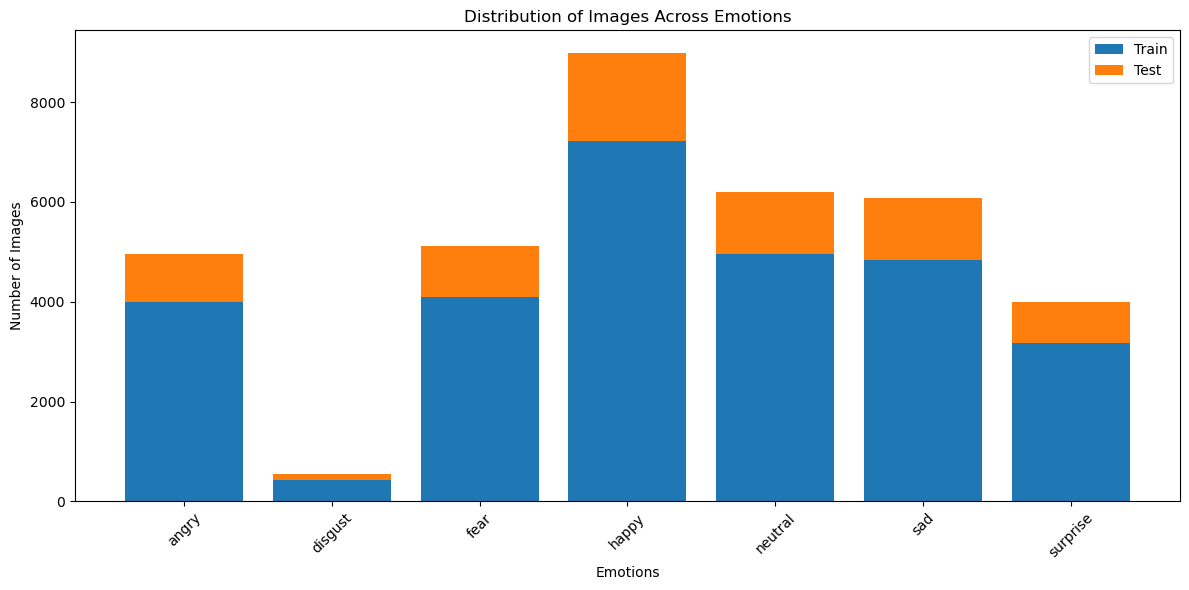

In [35]:
# Count images in each class
train_counts = [
    len(os.listdir(os.path.join(train_dir, emotion))) for emotion in emotions
]
test_counts = [len(os.listdir(os.path.join(test_dir, emotion))) for emotion in emotions]

# Plot distribution
plt.figure(figsize=(12, 6))
plt.bar(emotions, train_counts, label="Train")
plt.bar(emotions, test_counts, bottom=train_counts, label="Test")
plt.title("Distribution of Images Across Emotions")
plt.xlabel("Emotions")
plt.ylabel("Number of Images")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Drop Disgust

In [36]:
# Redefine emotions
emotions = ["angry", "fear", "happy", "neutral", "sad", "surprise"]

## Data Loading

### Data Generator Configuration

- **Why augment the training data?**
    - To reduce overfitting
    - To increase the number of training examples (with each transformation, we are adding more examples)
    - To improve the model's robustness to real-world variations in the data.

In [37]:
# Create data generators (returns batches of (images, labels) pairs during training)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, # normalizes images to 0-1 range
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

### Generator Creation

In [38]:
BATCH_SIZE = 64

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",  # one-hot encoding
    subset="training",
    classes= emotions
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
     classes= emotions
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",  # one-hot encoding
    shuffle=False,
    classes= emotions
)

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


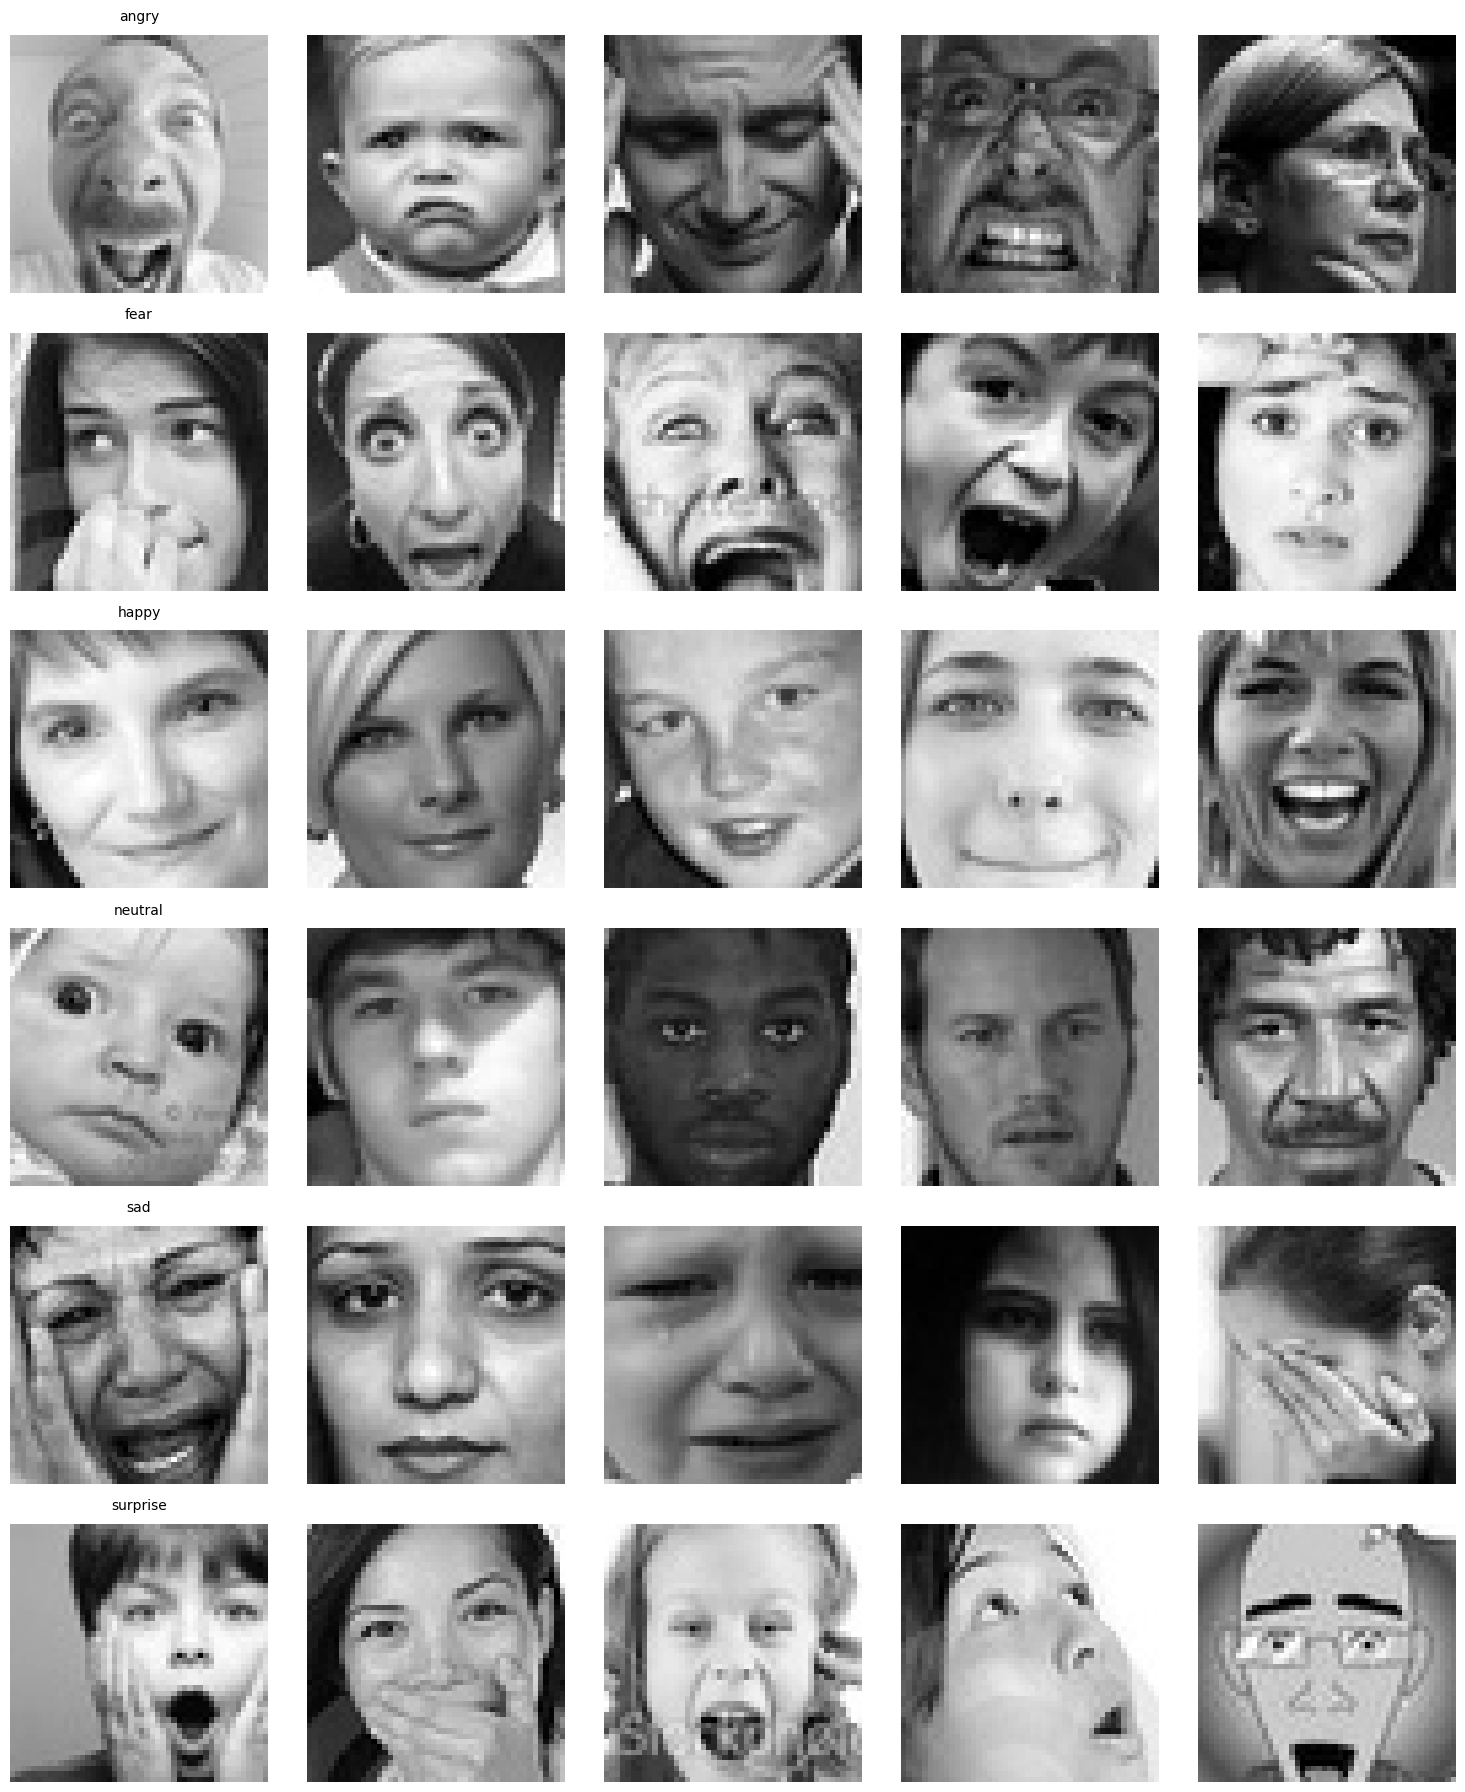

In [39]:
# Display 5 sample images for each emotion
plt.figure(figsize=(15, 21))

for i, emotion in enumerate(emotions):
    emotion_dir = os.path.join(train_dir, emotion)
    image_files = os.listdir(emotion_dir)[:5]  # first 5 images

    # Display 5 images for current emotion
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(emotion_dir, img_file)
        img = plt.imread(img_path)

        plt.subplot(7, 5, i * 5 + j + 1) # subplot index
        plt.imshow(img, cmap="gray")

        # add emotion label
        if j == 0:
            plt.title(f"{emotion}", fontsize=10, pad=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

## Machine Learning - CNN

In [40]:
model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Flatten(),
        Dense(1024, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(emotions), activation="softmax"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Training

In [41]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


353/353 ━━━━━━━━━━━━━━━━━━━━ 69s 193ms/step - accuracy: 0.1879 - loss: 2.7786 - val_accuracy: 0.1681 - val_loss: 2.1594
Epoch 2/50
  1/353 ━━━━━━━━━━━━━━━━━━━━ 1:09 197ms/step - accuracy: 0.1562 - loss: 2.5952

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1562 - loss: 2.5952 - val_accuracy: 0.1733 - val_loss: 2.1549
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.2302 - loss: 2.3952 - val_accuracy: 0.2878 - val_loss: 1.7750
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2188 - loss: 1.9095 - val_accuracy: 0.2898 - val_loss: 1.7713
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step - accuracy: 0.2399 - loss: 2.2408 - val_accuracy: 0.3159 - val_loss: 1.7603
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2656 - loss: 1.9372 - val_accuracy: 0.3111 - val_loss: 1.7705
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - accuracy: 0.2643 - loss: 2.1052 - val_accuracy: 0.3354 - val_loss: 1.6856
Epoch 8/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2969 - loss: 2.2110 - val_accuracy: 0.3363 - val_loss: 1.6791
Epoch 9/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 145s 410ms/step - accuracy: 0.2773 - loss: 2.0053 - val_accura

### Training History Visualization

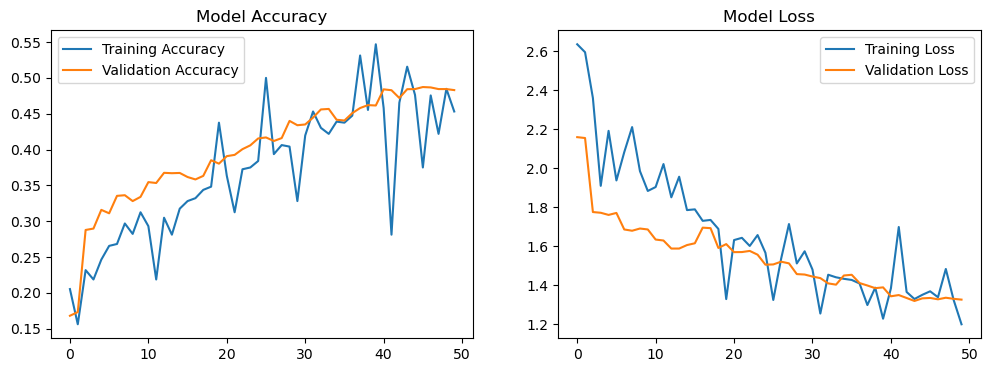

In [42]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.legend()
plt.show()

## Model Evaluation

In [43]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.4762 - loss: 1.3376
Test accuracy: 0.5321
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 


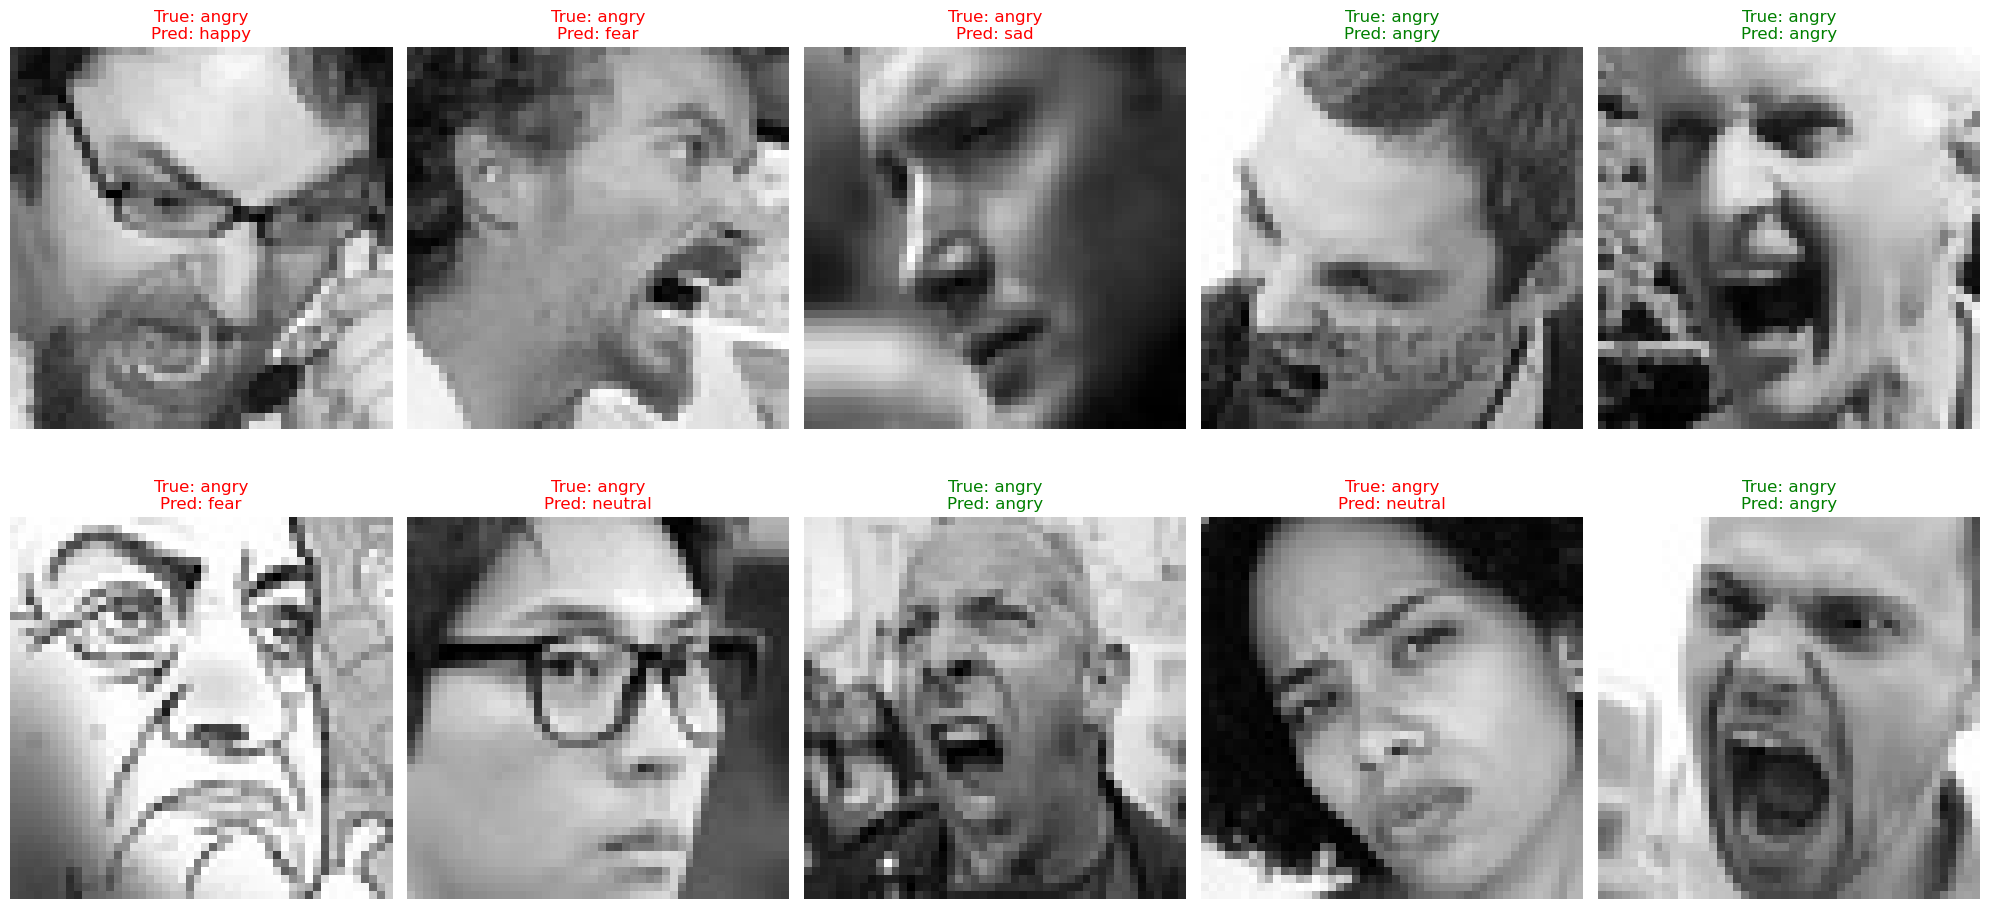

In [44]:
# Get a batch of test images and their predictions (for visualization)
test_generator.reset()
batch_x, batch_y = next(test_generator)
predictions = model.predict(batch_x)

# Plot sample predictions
plt.figure(figsize=(20, 10))
for i in range(min(10, len(batch_x))): # In case we don't have enough images
    plt.subplot(2, 5, i + 1)

    # Display image
    plt.imshow(batch_x[i].reshape(IMG_WIDTH, IMG_HEIGHT), cmap="gray")

    # Get true and predicted labels
    true_label = emotions[np.argmax(batch_y[i])]
    pred_label = emotions[np.argmax(predictions[i])]

    # Color code the title (green for correct, red for wrong)
    color = "green" if true_label == pred_label else "red"

    # Show prediction probabilities
    probs = [f"{emotions[j]}: {predictions[i][j]:.2f}" for j in range(len(emotions))]
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

### Confusion Matrix

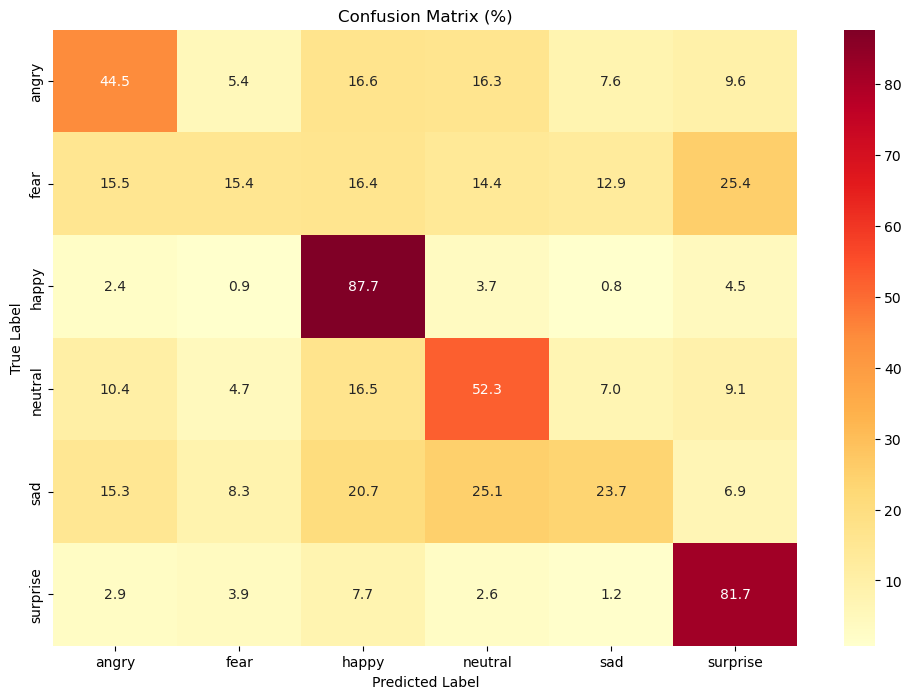

In [45]:
from sklearn.metrics import confusion_matrix

# Plot confusion matrix with percentages
cm = confusion_matrix(y_true, y_pred_classes)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 8))
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    xticklabels=emotions,
    yticklabels=emotions,
    cmap="YlOrRd",
)
plt.title("Confusion Matrix (%)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Prediction Confidence

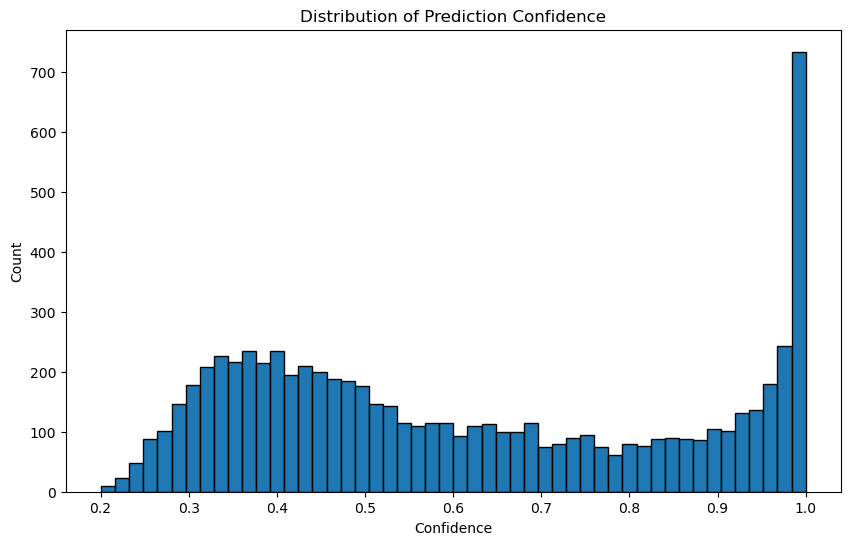

In [46]:
# Plot prediction confidence distribution
plt.figure(figsize=(10, 6))
confidences = np.max(y_pred, axis=1)

plt.hist(confidences, bins=50, edgecolor="black")
plt.title("Distribution of Prediction Confidence")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()

### Top Misclassifications

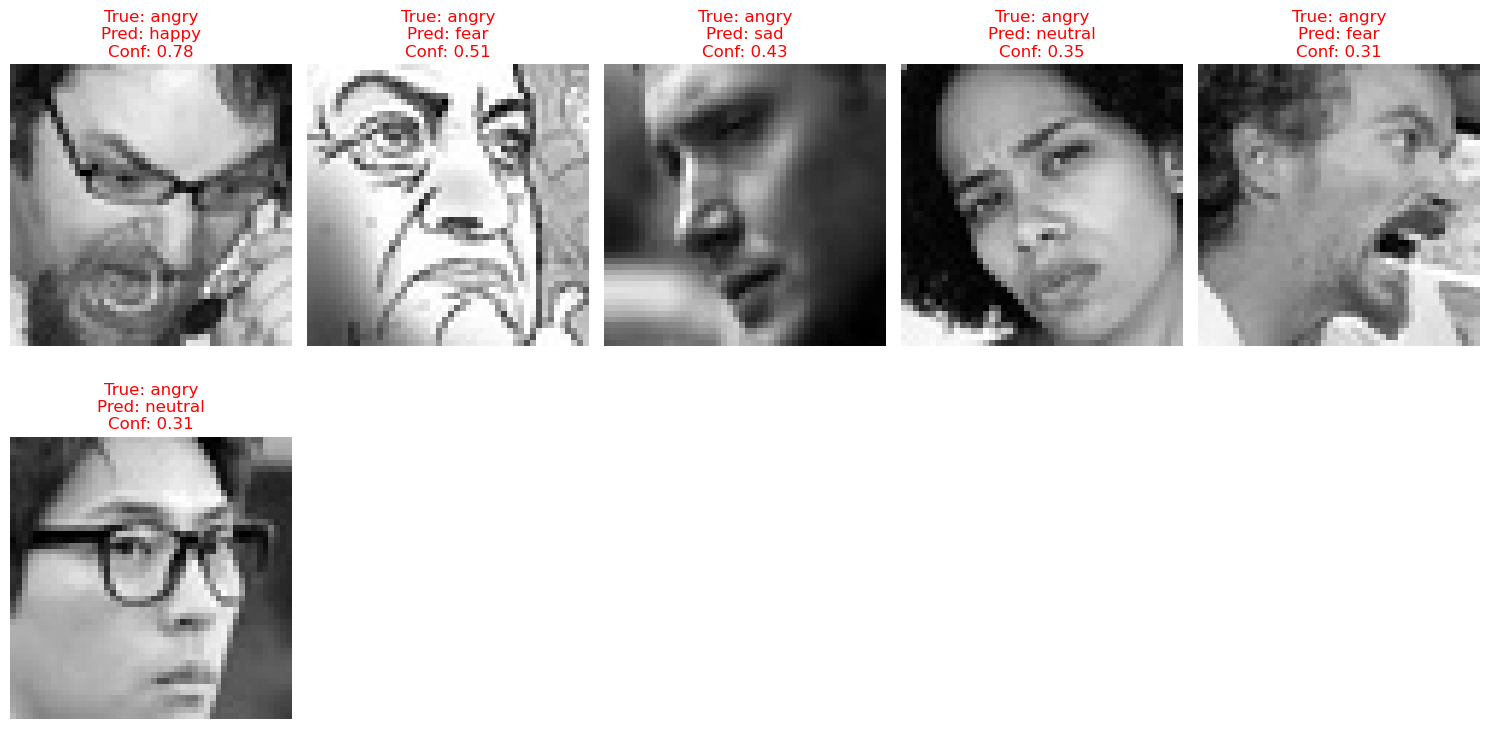

In [ ]:
# Plot top misclassifications
def get_top_misclassifications(batch_x, batch_y, predictions, n=5):
    misclass_conf = []
    for i in range(min(en(batch_x))): 
        true_label = np.argmax(batch_y[i])
        pred_label = np.argmax(predictions[i])
        if true_label != pred_label:
            conf = predictions[i][pred_label]
            misclass_conf.append((i, conf, true_label, pred_label))

    return sorted(misclass_conf, key=lambda x: x[1], reverse=True)[:n]


top_misclass = get_top_misclassifications(batch_x, batch_y, predictions, 10)

plt.figure(figsize=(15, 8))
for i, (idx, conf, true_label, pred_label) in enumerate(top_misclass):
    plt.subplot(2, 5, i + 1)
    plt.imshow(batch_x[idx].reshape(IMG_WIDTH, IMG_HEIGHT), cmap="gray")
    plt.title(
        f"True: {emotions[true_label]}\nPred: {emotions[pred_label]}\nConf: {conf:.2f}",
        color="red",
    )
    plt.axis("off")
plt.tight_layout()
plt.show()

### Classification Report

In [48]:
print(classification_report(y_true, y_pred_classes, target_names=emotions))

              precision    recall  f1-score   support

       angry       0.44      0.44      0.44       958
        fear       0.38      0.15      0.22      1024
       happy       0.65      0.88      0.74      1774
     neutral       0.48      0.52      0.50      1233
         sad       0.48      0.24      0.32      1247
    surprise       0.52      0.82      0.63       831

    accuracy                           0.53      7067
   macro avg       0.49      0.51      0.48      7067
weighted avg       0.51      0.53      0.50      7067



## Trying to understand what our model is seeing
- We can use grad cam vsualization to "see" what our model is seeing and the specific features of people's faces that the model is placing the most importance on.
- This allows us to see the reasons the differences in the model's jusdgements as we may be able to see the reasons for all the misclassfiications for so many of the facial expressions.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1531']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


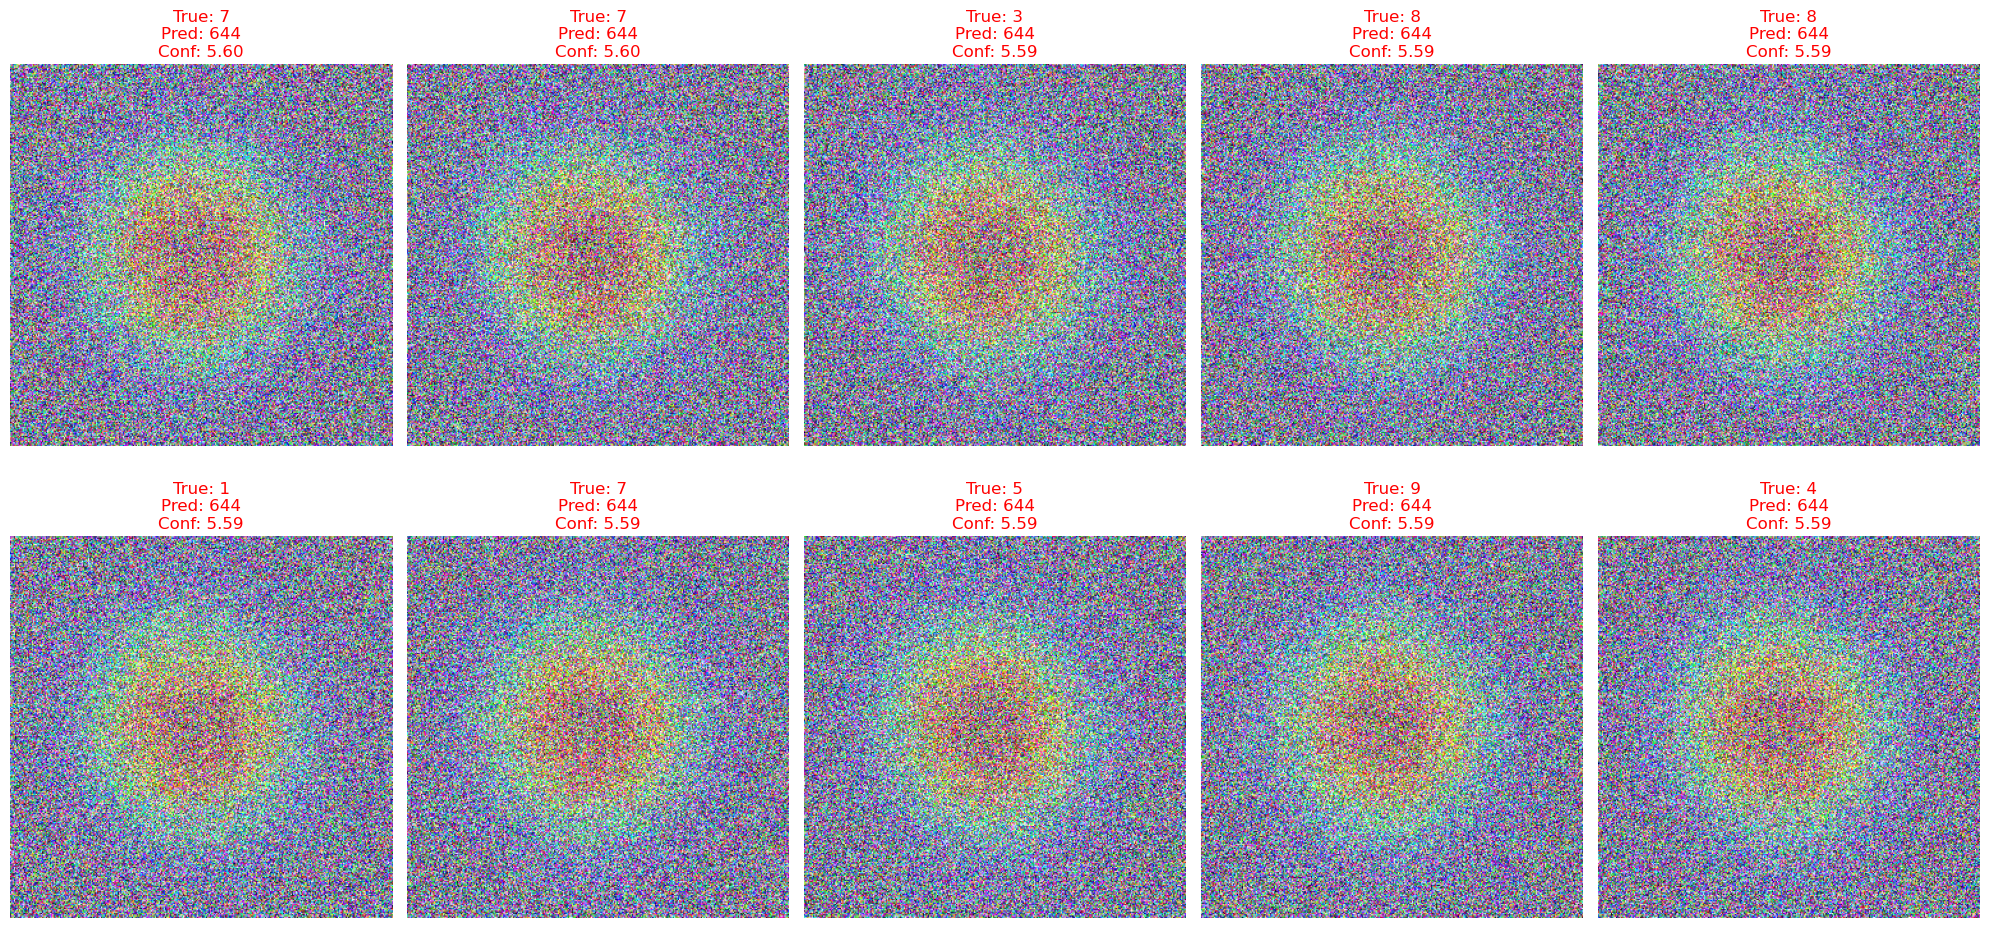

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl

# Model builder and preprocessing
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
last_conv_layer_name = "block14_sepconv2_act"

# Function to get top misclassifications
def get_top_misclassifications(batch_x, batch_y, predictions, n=5):
    misclass_conf = []
    for i in range(len(batch_x)):
        true_label = np.argmax(batch_y[i])
        pred_label = np.argmax(predictions[i])
        if true_label != pred_label:
            conf = predictions[i][pred_label]
            misclass_conf.append((i, conf, true_label, pred_label))

    return sorted(misclass_conf, key=lambda x: x[1], reverse=True)[:n]

# Function to create Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to save and display Grad-CAM on batch data with less heatmap opacity
def save_and_display_gradcam_on_batch(img_array, heatmap, alpha=0.05):
    """
    Superimpose Grad-CAM heatmap on the image array with less opacity on the heatmap 
    and higher clarity of the original image.
    """
    img = img_array[0]  # Remove batch dimension for visualization
    img = img - img.min()  # Normalize to [0, 1]
    img = img / img.max()

    # Scale heatmap to range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize the heatmap
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]  # RGB values
    jet_heatmap = jet_colors[heatmap]

    # Resize heatmap to match image dimensions
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose heatmap on the original image with reduced opacity for the heatmap
    superimposed_img = jet_heatmap * alpha + img * 255
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    
    # Adjust the opacity of the heatmap and the clarity of the original image
    superimposed_img = np.clip(jet_heatmap * 0.2 + img * 255, 0, 255).astype("uint8")
    
    return superimposed_img

# Model initialization and predictions
model = model_builder(weights="imagenet")
model.layers[-1].activation = None

# Example batch data (replace with your actual data)
batch_x = np.random.random((20, 299, 299, 3))  # Replace with actual image batch
batch_y = tf.keras.utils.to_categorical(np.random.randint(0, 10, size=(20,)), num_classes=10)  # Replace with actual labels
predictions = model.predict(preprocess_input(batch_x))

# Get top misclassifications
top_misclass = get_top_misclassifications(batch_x, batch_y, predictions, 10)

# Plot top misclassifications with Grad-CAM visualization
plt.figure(figsize=(20, 10))
for i, (idx, conf, true_label, pred_label) in enumerate(top_misclass):
    img_array = preprocess_input(np.expand_dims(batch_x[idx], axis=0))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_label)

    # Generate and superimpose heatmap
    superimposed_img = save_and_display_gradcam_on_batch(batch_x[idx:idx+1], heatmap)

    # Plot the resulting image with Grad-CAM overlay
    plt.subplot(2, 5, i + 1)
    plt.imshow(superimposed_img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}", color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Conclusions
- As we can see the model places too much value on the center of images which may not be the best representative of someone's facial expression.
- This highlights the limitations of machine learning as model's are unable to learn the same nuanced reasons for the reasoning algorithms that people use to judge facial expressions with.
- Mood, facial features,  and context are all things that we have learnt over time and it will take these models much more data before it is able to predict facial epxressions as well as people do.
- This has implications in places such as using machines for things such as criminal cases as a misclassification of someones facial expression may lead to false prision sentencing or corrupted data being sent to plice if camera footage from a crime scene is not always being evaluated by people. 

## Final thoughts

- We were surprised at the fact that the model had actually made strides in being able to make strides in learning how to recognize facial expressions despite limitaions with our data-set in its size and types of images with which the model was trained on.
- We recognize that the model was able to predict the model's scores with a non random level of accuracy that we are pleased with.
- Many human emptions can be confused for each other and especially the subtlty in how many emotions can be confused for each other is something that may take years of machine learning to train as it takes human being a lifetime to master ourselves.